# GoogleHashcode 2020 practice problem

- [Faris Hijazi](https://github.com/FarisHijazi)
- [Abdulmohsen Talal](https://github.com/mohsenTalal/HashCode)



## loading the data

In [45]:
!pip install line_profiler -q
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [0]:
import numpy as np
import os
import re
import itertools
from matplotlib import pyplot as plt


def read_file(fname):
    (max_slices, n_types), type2size = [list(map(int, line[:-1].split(' '))) for line in open(fname).readlines()]
    type2size = np.array(type2size)
    # plt.bar(np.arange(n_types), type2size)
    # plt.title(f'{fname}, max_slices={max_slices}, n_types={n_types}')
    # plt.show()
    return (max_slices, n_types), type2size


inputs = [
    'a_example.in',
    'b_small.in',
    'c_medium.in',
    'd_quite_big.in',
    'e_also_big.in',
]

In [0]:
infile = inputs[3]
(max_slices__, n_types__), type2size__ = read_file(infile)
"""
type2size: given the type, returns the size
size_of_i = type2size[i]
"""

print('max_slices:', max_slices__, 'ntypes:', n_types__)
print('type2size:', type2size__)

In [0]:
# the order will be a list of pizzas, it's length will be 
class Order(object):
    """
    contains info on an order

    the goal is to order as many slices as possible without
    """
    def __init__(self, infile, one_hot: np.array=None):
        """
        @param infile: str filename to read
        @param one_hot: a list of numbers corresponding to the number of pizzas for each type
            if 5 == one_hot[0], this means the order contains 5 orders of type 0.
        """
        self.infile = infile
        (self.max_slices, self.n_types), self.type2size = read_file(infile)

        self.one_hot = np.array(one_hot, dtype=int) if one_hot is not None \
            else np.zeros(self.n_types, dtype=int)
        
        if len(self.one_hot) != self.n_types:
            raise Exception('order_list must be same length of self.n_types')
        self.n_slices = 0

        # this is just a dictionary to keep track of random useful things
        self.state_dict = {}
    
    def count_slices(self) -> int:
        #TODO: this indexing can be optimized, see numpy
        return sum([self.type2size[i] * v for i, v in enumerate(self.one_hot)])

    def score(self, one_hot=None) -> int:
        """
        @returns the score for the order (number of slices) -1 if invalid
        """
        if one_hot is None:
            one_hot = self.one_hot

        n_slices = self.count_slices()
        if n_slices > self.max_slices or (one_hot>1).sum():
            # print(f'INVALID: n_slices:({n_slices}) > max_slices:({max_slices})')
            return n_slices - self.max_slices
        return n_slices
    def percent_score(self) -> float:
        return self.score()/self.max_slices*100.0
    
    def try_add_pizza(self, i) -> bool:
        """"""
        if self._can_add_pizza(i):
            self.one_hot[i] = 1
            self.n_slices += self.type2size[i]
            return True
        return False

    def _can_add_pizza(self, i) -> bool:
        return self.one_hot[i] != 1 and (self.max_slices - self.type2size[i] > self.n_slices)

    def add_pizza(self, i):
        """adds pizza to the order and accumulates the size"""
        if self.one_hot[i] == 1:
            raise Exception(f"can't add more than 1 pizza of each type."
                f"type {i} already existed in the order.")
        self.one_hot[i] = 1
        self.n_slices += self.type2size[i]
    
    def remove_pizza(self, i):
        if self.one_hot[i] == 0:
            raise Exception(f"can't remove a pizza that doesn't exist."
                f"type {i} didn't already existed in the order.")
        self.one_hot[i] = 0
        self.n_slices -= self.type2size[i]

    # bonus functions...

    def plot(self):
        used_boolarr = self.one_hot==1

        plt.bar(np.where(~used_boolarr)[0], self.type2size[~used_boolarr], label='unused')
        plt.bar(np.where(used_boolarr)[0], self.type2size[used_boolarr], label='used')
        plt.title(f'"{self.infile}", max_slices={self.max_slices}, n_types={self.n_types}')
        plt.legend()
        return plt.show()

    def get_output_str(self) -> str:
        out_str = str(self.one_hot.sum()) + '\n'
        pizzas = np.where(self.one_hot==1)[0]
        out_str += ' '.join(map(str, pizzas))
        return out_str
    
    def write_output(self):
        out_fname = re.sub('.in$', '.out', self.infile)
        os.makedirs('output', exist_ok=True)

        with open(os.path.join('output', out_fname), 'w') as file:
            file.write(self.get_output_str())
    
    def __repr__(self):
        return str('Order("{}",\tscore={:.6f}%({}/{}), {}'.format(
             self.infile, self.percent_score(), self.score(), self.max_slices, np.where(self.one_hot==1)[0]
        ))


Simple greedy approaches

We just sort and start from the largest

### Approach 1

sort in descending order and start putting larger pizzas first until 

<!-- ```algorithm
starting with large
``` -->

In [0]:
def greedy1(infile, verbose=False):
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
        if order.max_slices - order.type2size[i] > order.count_slices():
            order.one_hot[i] = 1
    
    if verbose:
        order.plot()
    
    print(order)
    return order


def greedy2(infile, verbose=False):
    """same as greedy1 but accumulates slices instead of counting everytime
    (much faster)
    """
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
        if order.max_slices - order.type2size[i] > order.n_slices:
            order.one_hot[i] = 1
            order.n_slices += order.type2size[i]
            
    if verbose:
        order.plot()
    
    print(order)
    return order

def greedy3(infile, verbose=False):
    """same as greedy1 but accumulates slices instead of counting everytime
    (much faster)
    """
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
       order.try_add_pizza(i)
    
    if verbose:
        order.plot()
    
    print(order)
    return order


## Improving the approach

the idea is that sometimes, if we remove a big piece and replace it with 2 small pieces, the sum is a bit greater

- TIP: see this post on how to efficiently map functions from numpy arrays: https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array/35216364

```algo
# a finished order is given

algorithm (order, iters):
    for i in range(iters):
        dist = order.max_slices - order.score # see how much is remaining to optimality
        unused = np.where(order.one_hot==0)[0]
        if dist <= 1:
            return order
        
        used_piece = get_random_used_piece(order) #randomly choose a used piece
        # find a combination of the unused s.t: used_piece < sum <= order.max_slices
        if found combo:
            remove that one piece
            add those 2 pieces

```


In [0]:

def improve_order(order, iters=300):
    # n_samples = 100
    if type(order) is str:
        order = greedy3(str(order))

    if order.score() < 0:
        raise NotImplementedError("Only VALID orders are supported")
    
    attempted_replacements = set()

    for i in range(iters):
        old_n_slices = order.n_slices # just keeping track for comparison

        dist = order.max_slices - order.score() # see how much is remaining to optimality
        unused_boolarr = order.one_hot==0
        unused = np.where(unused_boolarr)[0]
        print(f"iter[{i}]: distance={dist}", end='\t')

        if dist < 1:
            print(order)
            return order
 
        #TODO: use the `dist`, it can be useful
        # randomly choose a used piece

        # these are the used elements that we didn't attempt removing before
        sample_space = list(set(np.where(~unused_boolarr)[0]).difference(attempted_replacements))
        if not sample_space: # if already exhausted the used pizzas, just return
            print(order)
            return order

        used_piece = np.random.choice(sample_space)
        attempted_replacements.add(used_piece)

        # print(f"Let's try removing piece:{used_piece}", end='\t')

        # remove that one piece
        order.remove_pizza(used_piece)

        combo_size = 2
        # find a combination of the unused s.t: order.type2size[used_piece] < sum_of_pcs <= order.max_slices
        combos = list(itertools.combinations(unused, combo_size))

        # sums, only those that satisfy the constraint are kept
        def get_sum_of_pcs(tup):
            sum_of_pcs = order.type2size[np.array(tup)].sum()
            if order.type2size[used_piece] < sum_of_pcs and (order.n_slices + sum_of_pcs) <= order.max_slices:
                return sum_of_pcs
            else:
                return -99999999
        sums = list(map(get_sum_of_pcs, combos)) #FIXME: OPTIMIZE THIS
        filtered = list(filter(lambda sum_of_pcs: order.type2size[used_piece] < sum_of_pcs and (order.n_slices + sum_of_pcs) <= order.max_slices, sums))

        if len(filtered):
            max_idx = np.argmax(sums)
            new_pcs = combos[max_idx]
            
            # print('sums:', sums)
            # print('filtered:', filtered)
            # print('max_idx=', max_idx, 'new_pcs=', new_pcs)

            # add those 2 pieces
            for piece in new_pcs:
                order.add_pizza(piece)

            new_pc_sizes = [order.type2size[pc] for pc in new_pcs]
            print(f'improved +{order.n_slices-old_n_slices}slices ({old_n_slices}->{order.n_slices}).'
                  f'Did so by replacing a {order.type2size[used_piece]}slice pizza with pizzas of sizes {"+".join(map(str, new_pc_sizes))}={sum(new_pc_sizes)}')
            attempted_replacements.remove(used_piece)
        else:
            # put piece back
            order.add_pizza(used_piece)
            print(f'no luck')
    print(order)
    return order


def greedy4(infile, verbose=False, iters=300):
    """same as greedy 3 but with improving the order"""
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
       order.try_add_pizza(i)
    
    order = improve_order(order, iters=300)

    if verbose:
        print(order)
        order.plot()
    return order


# greedy4(inputs[4])

In [0]:
# testing stuff here

# list(itertools.combinations(np.arange(1000), 2))

In [147]:
r = %lprun -r -f improve_order improve_order(inputs[4], iters=2)
r.print_stats()

Order("e_also_big.in",	score=99.999997%(504999983/505000000), [ 266 5730 5731 ... 9997 9998 9999]
iter[0]: distance=17	Let's try removing piece:8579	improved +17slices (504999983->505000000).Did so by replacing a 128611slice pizza with pizzas of sizes 42614+86014=128628
iter[1]: distance=0	Order("e_also_big.in",	score=100.000000%(505000000/505000000), [ 266 2849 5707 ... 9997 9998 9999]
Timer unit: 1e-06 s

Total time: 106.061 s
File: <ipython-input-144-f5dd146b5da2>
Function: improve_order at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def improve_order(order, iters=300):
     3                                               # n_samples = 100
     4         1          6.0      6.0      0.0      if type(order) is str:
     5         1      49090.0  49090.0      0.0          order = greedy3(str(order))
     6                                           
     7         1       6551.0   6551.0      0.0      if order.

improve_order line profile

notice the line of `list(sums)` is taking most of the time, this is because it has to execute all the mapping and the comparison, we can make this more efficient using numpy.

    42       300    3911810.0  13039.4     80.5          sums = list(sums)

I tried using `sums = np.fromiter(sums, int)` instead to speed things up, unfortunately no dice.  
Now for tha `map()`, it seems that there's no way to speed it up, so I'm thinking maybe we could just use `list(map(...))` normally, but for `filter(...)`, we could use the numpy boolean arrays to make things more efficient, I got the following results:

```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     ....
     ....
    39       300    3715147.0  12383.8     61.1          sums = list(map(lambda tup: sum([order.type2size[i] for i in tup]), combos))
    40 ....
    41       300    1315154.0   4383.8     21.6          sums = list(filter(lambda sum_of_pcs: order.type2size[used_piece] < sum_of_pcs and                            (order.n_slices + sum_of_pcs) <= order.max_slices, sums))
    42                                           
```

So we can see that `map()` is taking up x3 times more time than the `filter()` (which is unfortunate cuz we can't speed up the map much).



In [139]:
r = %lprun -r -f greedy1 greedy1('d_quite_big.in', verbose=True)
r.print_stats()

*** KeyboardInterrupt exception caught in code being profiled.Timer unit: 1e-06 s

Total time: 11.8433 s
File: <ipython-input-10-61fa345ad3ef>
Function: greedy1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def greedy1(infile, verbose=False):
     2         1       2511.0   2511.0      0.0      order = Order(infile)
     3                                               # i: index of pizza
     4      2001       2748.0      1.4      0.0      for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
     5      2000    2464074.0   1232.0     20.8          if order.max_slices - order.type2size[i] > order.count_slices():
     6      1812       5383.0      3.0      0.0              order.one_hot[i] = 1
     7                                               
     8         1          1.0      1.0      0.0      if verbose:
     9         1    9368619.0 9368619.0     79.1          order.plot()
   

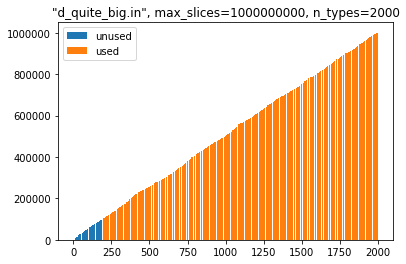

Order("d_quite_big.in",	score=99.999972%(999999725/1000000000), [  17  189  190 ... 1997 1998 1999]
Timer unit: 1e-06 s

Total time: 7.6318 s
File: <ipython-input-10-61fa345ad3ef>
Function: greedy2 at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def greedy2(infile, verbose=False):
    16                                               """same as greedy1 but accumulates slices instead of counting everytime
    17                                               (much faster)
    18                                               """
    19         1       1745.0   1745.0      0.0      order = Order(infile)
    20                                               # i: index of pizza
    21      2001       2066.0      1.0      0.0      for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
    22      2000       2772.0      1.4      0.0          if order.max_slices - order.type2size[i] > order.n_sl

In [140]:
r = %lprun -r -f greedy2 greedy2('d_quite_big.in', verbose=True)
r.print_stats()

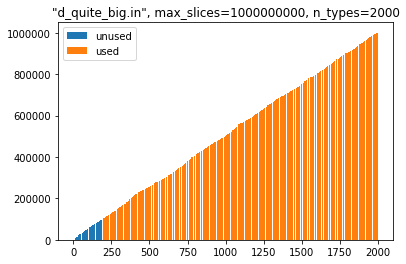

Order("d_quite_big.in",	score=99.999972%(999999725/1000000000), [  17  189  190 ... 1997 1998 1999]
Timer unit: 1e-06 s

Total time: 7.99002 s
File: <ipython-input-10-61fa345ad3ef>
Function: greedy3 at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
    32                                           def greedy3(infile, verbose=False):
    33                                               """same as greedy1 but accumulates slices instead of counting everytime
    34                                               (much faster)
    35                                               """
    36         1       1368.0   1368.0      0.0      order = Order(infile)
    37                                               # i: index of pizza
    38      2001       2087.0      1.0      0.0      for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
    39      2000       7405.0      3.7      0.1         order.try_add_pizza(i)
    40                        

In [141]:
r = %lprun -r -f greedy3 greedy3('d_quite_big.in', verbose=True)
r.print_stats()

In [150]:
for input in inputs:
    order = greedy4(input)
    order.write_output()

iter[0]: distance=1	no luck
iter[1]: distance=1	no luck
iter[2]: distance=1	no luck
iter[3]: distance=1	Order("a_example.in",	score=94.117647%(16/17), [0 2 3]
iter[0]: distance=1	improved +1slices (99->100).Did so by replacing a 95slice pizza with pizzas of sizes 14+82=96
iter[1]: distance=0	Order("b_small.in",	score=100.000000%(100/100), [0 1 7]
iter[0]: distance=5	improved +1slices (4495->4496).Did so by replacing a 63slice pizza with pizzas of sizes 32+32=64
iter[1]: distance=4	no luck
iter[2]: distance=4	no luck
iter[3]: distance=4	no luck
iter[4]: distance=4	no luck
iter[5]: distance=4	no luck
iter[6]: distance=4	no luck
iter[7]: distance=4	no luck
iter[8]: distance=4	no luck
iter[9]: distance=4	no luck
iter[10]: distance=4	no luck
iter[11]: distance=4	no luck
iter[12]: distance=4	no luck
iter[13]: distance=4	no luck
iter[14]: distance=4	no luck
iter[15]: distance=4	no luck
iter[16]: distance=4	no luck
iter[17]: distance=4	no luck
iter[18]: distance=4	no luck
iter[19]: distance=4	

In [0]:
# import numpy as np
# from scipy.optimize import minimize


# def rosen(x):
#     """The Rosenbrock function"""
#     return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


# x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
# res = minimize(rosen, x0, method='nelder-mead',
#                options={'xatol': 1e-8, 'disp': True})